Developing a script to download all WPQs into a csv, and subsequently to update that CSV. 

In [1]:
import requests
import json
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()
import os
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# tmp = 'Users/ben/Documents/blog/UKParliament/tmp/'

In [3]:
active_p = pd.read_csv('active_members.csv')
former_p = pd.read_csv('former_members.csv')

In [4]:
all_p = pd.concat([active_p, former_p])
all_p = all_p[['id', 'nameListAs', 'gender', 'latestPartyabbreviation']]

In [5]:
all_p[all_p.id == 4356]

,id,nameListAs,gender,latestPartyabbreviation
437,4356,"Rayner, Angela",F,Lab


In [6]:
id_party_dict = dict(zip(all_p.id, all_p.latestPartyabbreviation))

In [7]:
wpqs = pd.read_csv('/Users/ben/Documents/blog/pqs/tmp/pqs.csv')
wpqs['dateAnswered'] = pd.to_datetime(wpqs.dateAnswered)
wpqs['heading'] = wpqs.heading.fillna('')
wpqs = wpqs[['id', 'askingMemberId', 'askingMember', 'house', 'dateAnswered', 'questionText', 'answeringBodyName', 'answerText', 'heading']]

# Populate a column with party appreviation in the WPQs database
wpqs['latestPartyabbreviation'] = wpqs.askingMemberId.progress_apply(lambda x: id_party_dict[x] if x in id_party_dict.keys() else 'n/a')

100%|███████████████████████████████████| 383178/383178 [00:00<00:00, 1441119.26it/s]


In [8]:
wpqs['heading'] = wpqs.heading.progress_apply(lambda x: x.lower())
wpqs['answerText'] = wpqs.answerText.progress_apply(lambda x: x.lower())
wpqs['questionText'] = wpqs.questionText.progress_apply(lambda x: x.lower())

100%|███████████████████████████████████| 383178/383178 [00:00<00:00, 1255984.28it/s]


In [9]:
# Sometime the heading is a generic topic, other times it's specified by a ":" symbol. We'll extract this into a 'topic' column.
wpqs['topic'] = wpqs.heading.progress_apply(lambda x: x.split(':')[0])

100%|███████████████████████████████████| 383178/383178 [00:00<00:00, 1536116.56it/s]


In [10]:
wpqs['year'] = wpqs.dateAnswered.dt.year

In [11]:
wpqs['year_month'] = wpqs.dateAnswered.dt.to_period('M')

In [12]:
wpqs.head()

,id,askingMemberId,askingMember,house,dateAnswered,questionText,answeringBodyName,answerText,heading,latestPartyabbreviation,topic,year,year_month
0,58429,437,NaN,Commons,2014-06-12,"to ask mr chancellor of the exchequer, how muc...",HM Treasury,table 1: bolton north east constituency workin...,working tax credit: bolton,Lab,working tax credit,2014,2014-06
1,57913,4031,NaN,Commons,2014-06-10,"to ask mr chancellor of the exchequer, what th...",HM Treasury,the following table is based on finalised tax ...,welfare tax credits,Lab,welfare tax credits,2014,2014-06
2,61038,4031,NaN,Commons,2014-06-17,"to ask mr chancellor of the exchequer, what th...",HM Treasury,the following table is based on finalised tax ...,welfare tax credits,Lab,welfare tax credits,2014,2014-06
3,61086,1503,NaN,Commons,2014-06-16,"to ask the secretary of state for health, how ...",Department of Health,the department set up health education england...,general practitioners,Lab,general practitioners,2014,2014-06
4,60619,1565,NaN,Commons,2014-06-16,"to ask the secretary of state for justice, how...",Ministry of Justice,keeping the public safe is our priority. that ...,open prisons,Con,open prisons,2014,2014-06


### Most popular issues over time

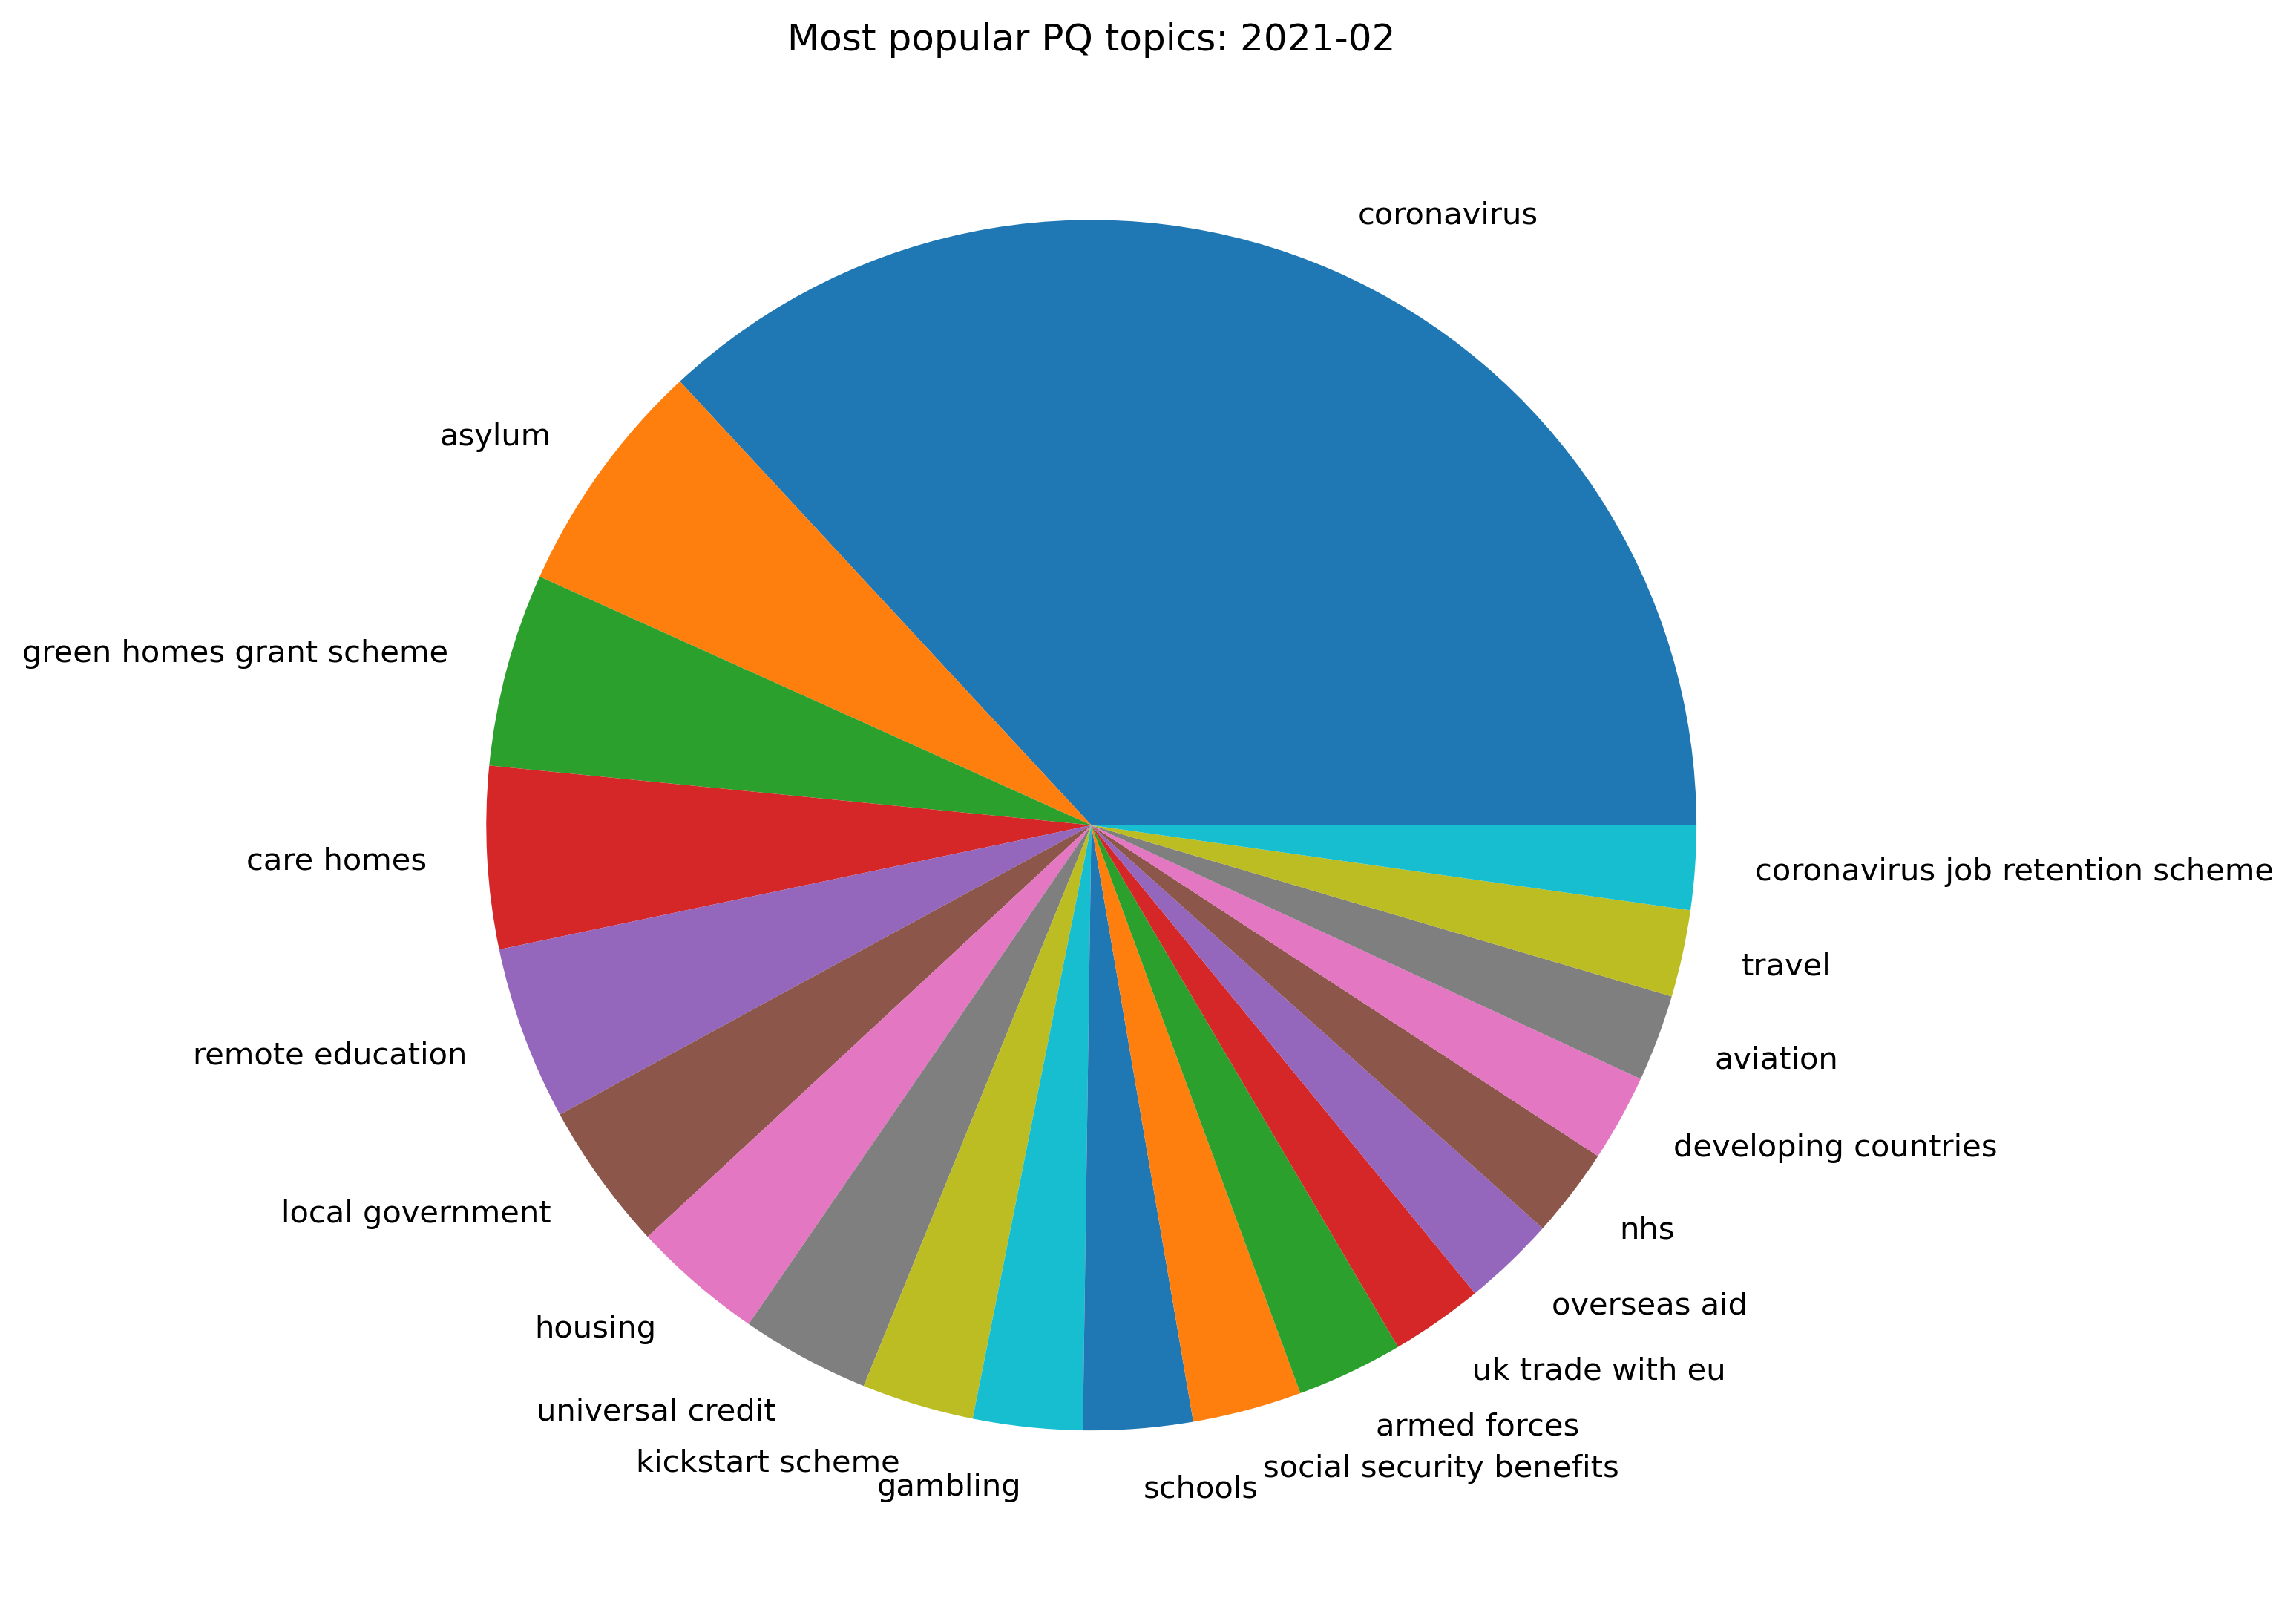

In [13]:
# And the all-time most popular issue is...! 

fig, ax = plt.subplots(figsize=(14, 9), dpi=300)

month = '2021-02'

wpqs[wpqs.year_month == month].topic.value_counts().head(20).plot(kind='pie', ax=ax, legend=False, xticks=[])
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Most popular PQ topics: {m}'.format(m=month))

fig.savefig('pqs_plots/most_popular_{m}'.format(m=month))
plt.show()

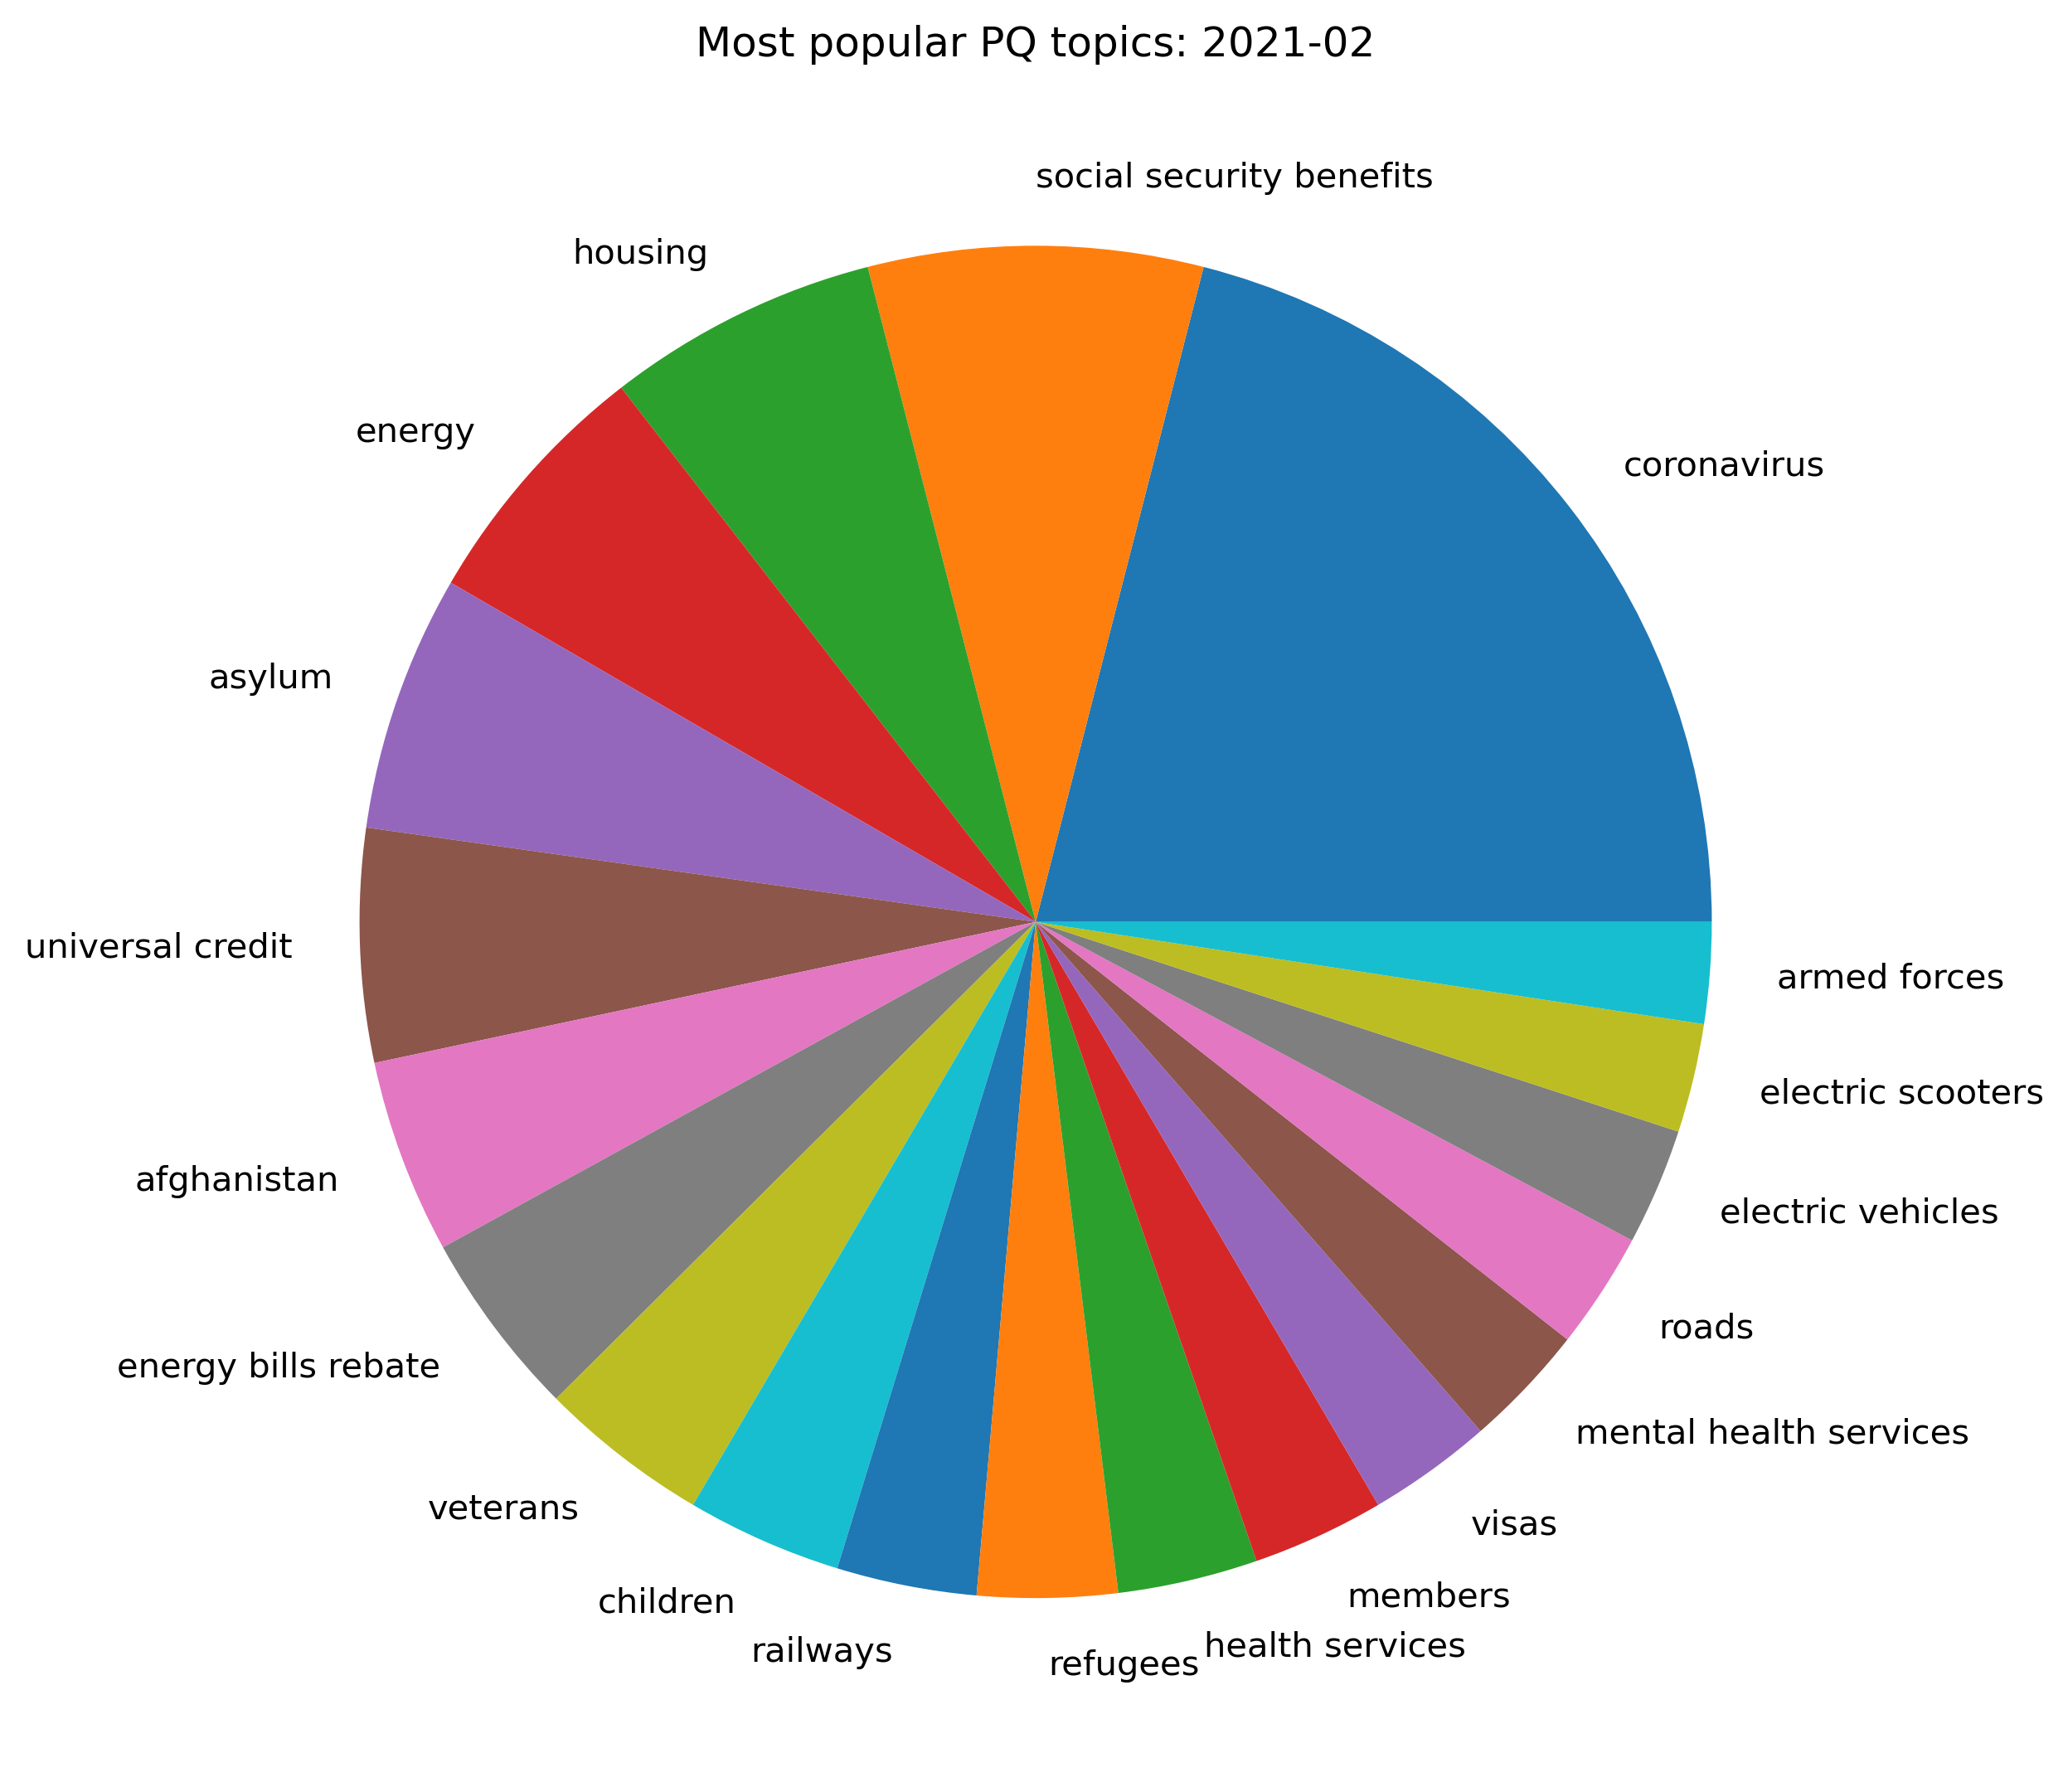

In [14]:
# And the all-time most popular issue is...! 

fig, ax = plt.subplots(figsize=(14, 9), dpi=300)

# month = '2021-02'

wpqs[wpqs.dateAnswered > '2022-02-21'].topic.value_counts().head(20).plot(kind='pie', ax=ax, legend=False, xticks=[])
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Most popular PQ topics: {m}'.format(m=month))

fig.savefig('pqs_plots/most_popular_{m}'.format(m=month))
plt.show()

In [15]:
month = '2022-02'
top = wpqs[wpqs.year_month == month].topic.value_counts(1).head(20) * 100
top_df = top.to_frame()
top_df['topic'] = top_df.topic.round(2)
# print(top_df.to_markdown())

| topic                             | % of PQs |
|:----------------------------------|---------:|
| coronavirus                       | 3.25753  |
| energy                            | 1.81315  |
| asylum                            | 1.5673   |
| social security benefits          | 1.25999  |
| afghanistan                       | 1.01414  |
| mental health services            | 0.952674 |
| driving licences                  | 0.891211 |
| prime minister                    | 0.891211 |
| railways                          | 0.860479 |
| universal credit                  | 0.860479 |
| energy bill discount scheme       | 0.860479 |
| children                          | 0.860479 |
| dental services                   | 0.860479 |
| courts                            | 0.799017 |
| housing                           | 0.768285 |
| schools                           | 0.768285 |
| immigration                       | 0.737554 |
| regional planning and development | 0.737554 |
| business                          | 0.706822 |
| health services                   | 0.706822 |

In [16]:
# Top most popular issues of all time
top = wpqs.topic.value_counts().head(10).index.tolist()

# List of months
months = wpqs.year_month.drop_duplicates().tolist()

# empty list to contain the pandas series objects we'll create
series = []

# Filter out our database so that it only contains topics that are in our list, 'top'
wpqs_sel = wpqs[wpqs.topic.isin(top)]

# Iteratre through the months and get the values
for month in tqdm(months):
    s = wpqs_sel[wpqs_sel.year_month == month].topic.value_counts()
    s.name = month
    series.append(s)
    
    
top_df = pd.DataFrame(series)
top_df = top_df.sort_index()
top_df = top_df.dropna(axis=0, thresh=5)

100%|██████████████████████████████████████████████| 91/91 [00:00<00:00, 1681.32it/s]


In [17]:
# Top most popular issues of all time
top_n = wpqs.topic.value_counts().head(10).index.tolist()

# List of months
months = wpqs.year_month.drop_duplicates().tolist()

series_n = []

wpqs_sel = wpqs[wpqs.topic.isin(top_n)]

for month in tqdm(months):
    s = wpqs_sel[wpqs_sel.year_month == month].topic.value_counts(normalize=True)
    s.name = month
    series_n.append(s)
    
top_df_n = pd.DataFrame(series_n)
top_df_n = top_df_n.sort_index()
top_df_n = top_df_n.dropna(axis=0, thresh=5)

100%|██████████████████████████████████████████████| 91/91 [00:00<00:00, 1699.63it/s]


In [18]:
# Top most popular issues of all time
top_n = wpqs.topic.value_counts().index.tolist()
# top_n = ['brexit']

# List of months
months = wpqs.year_month.drop_duplicates().tolist()

series_n = []

wpqs_sel = wpqs[wpqs.topic.isin(top_n)]

for month in tqdm(months):
    s = wpqs_sel[wpqs_sel.year_month == month].topic.value_counts(normalize=True)
    s.name = month
    series_n.append(s)
    
top_df_n = pd.DataFrame(series_n)
top_df_n = top_df_n.sort_index()
top_df_n = top_df_n.dropna(axis=0, thresh=5)

100%|███████████████████████████████████████████████| 91/91 [00:00<00:00, 556.30it/s]


In [19]:
top_df_n.loc['2022-01'].sort_values()

chevening scholarships programme          0.000175
trams                                     0.000175
renewable fuels                           0.000175
personation                               0.000175
national institute for health research    0.000175
                                            ...   
raf manston                                    NaN
antitank missiles                              NaN
forests and wildlife                           NaN
vaccine data resolution service                NaN
natural fibres                                 NaN
Name: 2022-01, Length: 14460, dtype: float64

In [20]:
top_df_n

,children,personal independence payment,disciplinary proceedings,developing countries,energy,army,equality,railways,general practitioners,universal credit,...,ear wax,absenteeism,erasmus+ programme and european solidarity corps,additional restrictions grant and omicron hospitality and leisure grant,cushman and wakefield,raf manston,antitank missiles,forests and wildlife,vaccine data resolution service,natural fibres
2014-06,0.017041,0.012843,0.010126,0.010126,0.009138,0.009138,0.008644,0.008150,0.007903,0.007903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07,0.010496,0.008358,0.000389,0.005248,0.008941,0.001166,NaN,0.011662,0.005831,0.009524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,0.005208,NaN,NaN,0.002604,0.005208,0.005208,NaN,NaN,0.002604,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,0.004614,0.006292,NaN,0.001678,0.012164,0.003356,NaN,0.007970,0.003775,0.003775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10,0.010710,0.008835,NaN,0.003213,0.005355,0.000535,NaN,0.003748,0.008032,0.007229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11,0.005618,0.002148,NaN,0.003305,0.002148,0.001487,0.000330,0.011897,0.006775,0.006114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12,0.005236,0.000683,NaN,0.001593,0.002959,0.006146,0.000228,0.011382,0.005236,0.006146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01,0.003152,0.001226,NaN,0.001926,0.005778,0.000350,0.000700,0.007354,0.002977,0.002276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02,0.006692,0.003075,NaN,0.001809,0.013565,0.000543,0.000181,0.007777,0.001990,0.008320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


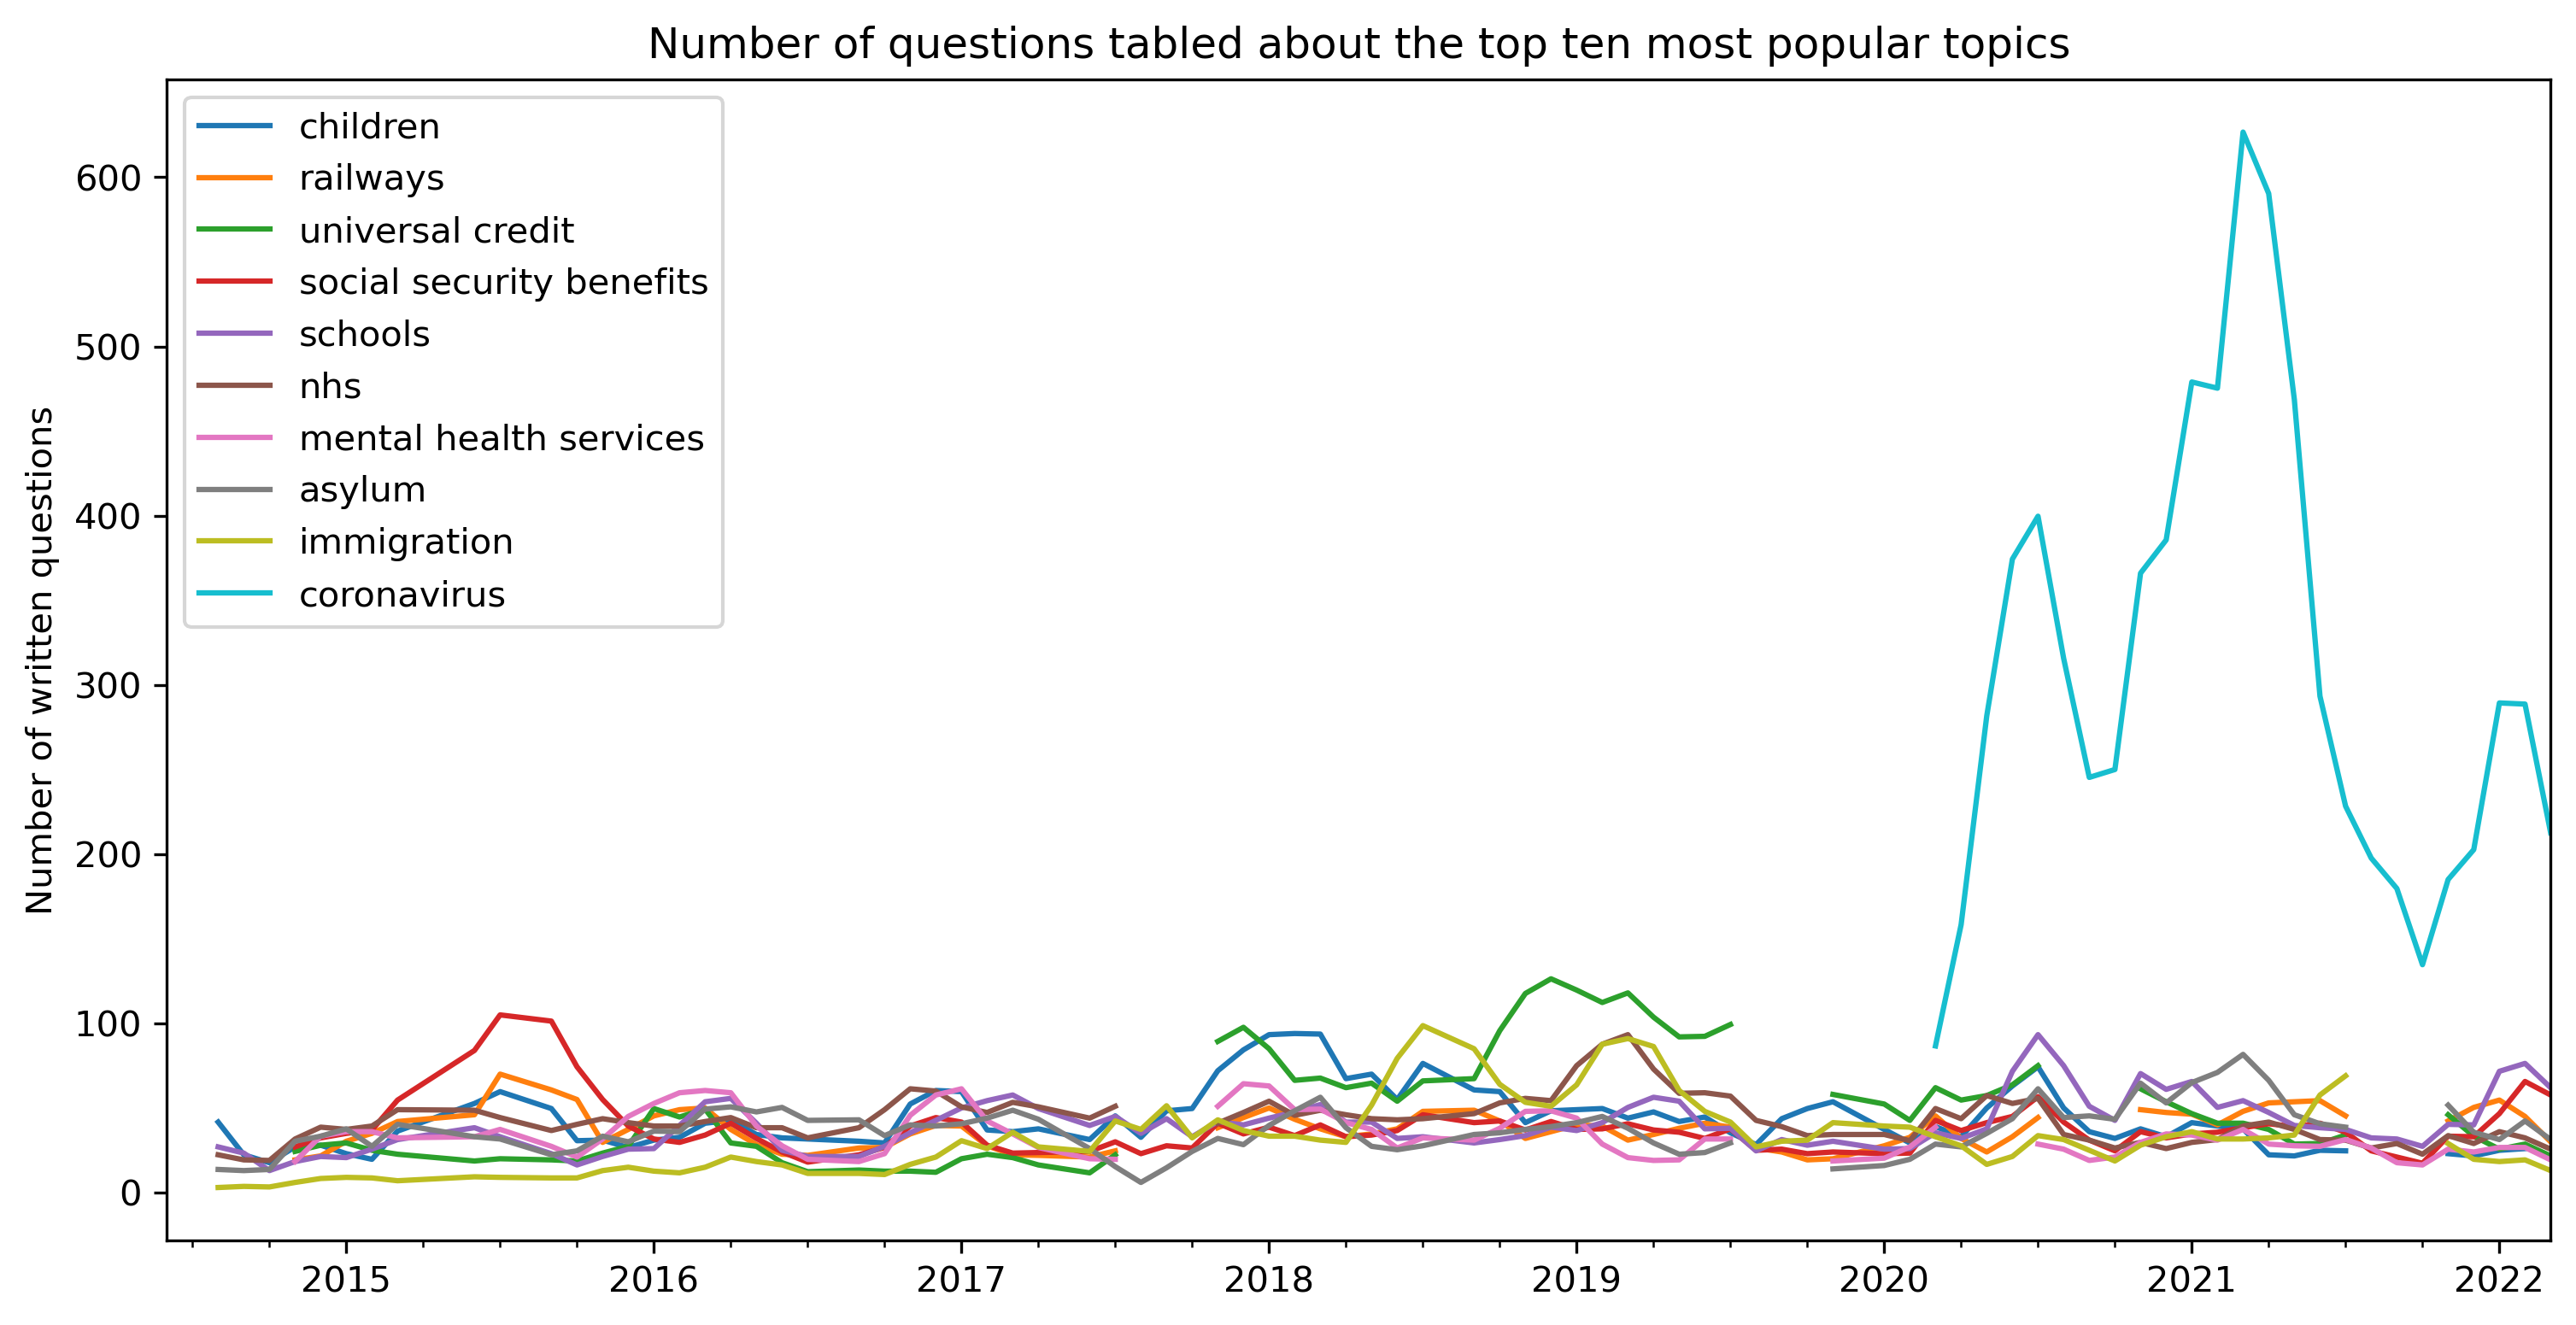

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)

ax1.set_title('Number of questions tabled about the top ten most popular topics')
ax1.set_ylabel('Number of written questions')
top_df.rolling(3).mean().plot(ax=ax1)

fig.savefig('pqs_plots/top_10_pqs_vol.png')
plt.show()

In [ ]:
fig, ax2 = plt.subplots(figsize=(12, 6), dpi=300)

ax2.set_title('Share of questions tabled about the top ten most popular topics\n6 month rolling average')
ax2.set_ylabel('Share of written questions')
top_df_n.rolling(6).mean().plot(ax=ax2)

plt.show()

In [ ]:
# Monthly most popular issues
wpqs_monthly = wpqs.copy()
wpqs_monthly = wpqs_monthly[['year_month', 'topic', 'askingMemberId']]
wpqs_monthly = wpqs_monthly[wpqs_monthly.topic.str.contains('russia')]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.set_title('Number of MPs asking about issue')
ax.set_ylabel('MPs (#)')

wpqs_monthly.groupby(['year_month']).nunique().askingMemberId.rolling(3).mean().plot(ax=ax)
ax.set_xlabel('Date')

# fig.savefig('pqs_plots/total_pqs_monthly.png')

plt.show()

In [ ]:
# We need to iterate through the issues and then go from there
wpqs_monthly_i = wpqs.copy()
wpqs_monthly_i = wpqs_monthly_i[['year_month', 'topic', 'askingMemberId']]

# Transform the dataset, counting the number of unique MP ids associated with any topic, giving us a dataset
wpqs_monthly_i = wpqs_monthly_i.groupby(['year_month', 'topic']).nunique().reset_index()

In [ ]:

keyword = 'asylum'
wpqs_monthly_i[wpqs_monthly_i.topic == keyword].rolling(3).mean().plot()

In [ ]:
mps_pqs = wpqs_monthly_i.sort_values(['year_month', 'askingMemberId']).set_index('year_month')

In [ ]:
mps_pqs[mps_pqs.index == '2022-02'].sort_values('askingMemberId').head(3)

In [ ]:
lst_tops = []

for m in mps_pqs.index.unique().tolist():
    lst_tops.append(mps_pqs[mps_pqs.index == m].sort_values('askingMemberId', ascending=False).head(3))
    
top_3_monthly = pd.concat(lst_tops)

In [ ]:
top_3_monthly.topic.value_counts()

In [ ]:
mps_pqs.askingMemberId.index

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

rolling = 12

# mps_pqs[mps_pqs.topic == 'coronavirus'].askingMemberId.plot(ax=ax)
mps_pqs[mps_pqs.topic == 'energy'].askingMemberId.rolling(rolling).mean().plot(ax=ax, c='g', label='Energy')
mps_pqs[mps_pqs.topic == 'refugees'].askingMemberId.rolling(rolling).mean().plot(ax=ax, c='y', label='Refugees')
# mps_pqs[mps_pqs.topic == 'nhs'].askingMemberId.rolling(rolling).mean().plot(ax=ax, c='r', label='NHS')
mps_pqs[mps_pqs.topic == 'schools'].askingMemberId.rolling(rolling).mean().plot(ax=ax, c='b', label='Schools')
mps_pqs[mps_pqs.topic == 'brexit'].askingMemberId.rolling(rolling).mean().plot(ax=ax, c='r', label='Brexit')



ax.legend()
plt.show()

### Monthly total WPQs tabled by each party's MPs

In [ ]:
# Weekly total PQs with a particular keyword. 
wpqs_mt = wpqs.copy()
wpqs_mt = wpqs_mt
wpqs_mt['topic'] = wpqs_mt.topic.fillna('')
# wpqs_mt = wpqs_mt[wpqs_mt.topic == 'ukraine']
# wpqs_mt = wpqs_mt[wpqs_mt.questionText.str.contains('charge point')]


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.set_title('Number of PQs tabled every month')
ax.set_ylabel('PQs (#)')

wpqs_mt.groupby(['year_month']).count().id.rolling(1).mean().plot(ax=ax)
ax.set_xlabel('Date')

fig.savefig('pqs_plots/total_pqs_monthly.png')

plt.show()

In [ ]:
wpqs_mt = wpqs_mt.set_index('dateAnswered')[['latestPartyabbreviation']]
wpqs_mt['count'] = 1

In [ ]:
wpqs_mt = wpqs_mt.groupby(['dateAnswered', 'latestPartyabbreviation']).sum().reset_index('latestPartyabbreviation').pivot(columns='latestPartyabbreviation', values='count').resample('W').sum()

In [ ]:
wpqs_mt.head()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

rp = 1

# ax.plot(wpqs_mt.rolling(rp).mean().Lab, c='r', label='Labour')
# ax.plot(wpqs_mt.rolling(rp).mean().Con, c='b', label='Conservative')
# ax.plot(wpqs_mt.rolling(rp).mean().SNP, c='y', label='SNP')
# ax.plot(wpqs_mt.rolling(rp).mean().LD, c='gold', label='Lib Dem')
ax.plot(wpqs_mt.rolling(rp).mean().sum(axis=1), c='black', label='Total')
# ax.plot(wpqs_mt.rolling(rp).mean().Green, c='g', label='Green')

ax.set_title('Volume of Written Parliamentary Questions by each Party (Commons)')

ax.legend()

# wpqs_mt.plot(ax=ax)

#### Number of MPs asking about a particular issue in a month

Volume of questions could be misleading, since MPs may table several questions to several different departments about one issue, and only one PQ to another department about another issue, yet care about both issues equally. Volume of questions is therefore an inaccurate measure of an issue's level of interest. 

This **will be** a script to examine the numbers of MPs asking about any particular issue in a given month. 

In [ ]:
wpqs_mp_num = wpqs.copy()
wpqs_mp_num = wpqs_mp_num[wpqs_mp_num.house == 'Commons']
wpqs_mp_num['heading'] = wpqs_mp_num.heading.fillna('')
wpqs_mp_num['issue'] = ''
wpqs_mp_num['issue'] = wpqs_mp_num.progress_apply(lambda row: 'russia' if ('russia' or 'ukraine') in row['questionText'] else row['issue'], axis=1)
wpqs_mp_num['issue'] = wpqs_mp_num.progress_apply(lambda row: 'evs' if ('electric vehicle' or 'electric car' or 'charge point') in row['questionText'] else row['issue'], axis=1)

In [ ]:
wpqs_mp_num = wpqs_mp_num.groupby(['dateAnswered', 'askingMemberId', 'issue']).count()[['id']].reset_index(['askingMemberId', 'issue'])

In [ ]:
wpqs_mp_num['number_mps'] = 1

In [ ]:
wpqs_mp_num = wpqs_mp_num.groupby(['dateAnswered', 'issue']).sum()

In [ ]:
wpqs_mp_num.reset_index(inplace=True)

In [ ]:
wpqs_mp_num.head()

In [ ]:
wpqs_mp_num.issue.value_counts()

In [ ]:
wpqs_mp_num['month'] = wpqs_mp_num['dateAnswered'].dt.to_period('M')

# pd.to_datetime(df['birth_date']).dt.to_period('M')

In [ ]:
wpqs_mp_num = wpqs_mp_num.groupby(['month', 'issue']).sum()[['id', 'number_mps']].reset_index('issue')

In [ ]:
# Most consistently PQ'ed issues:
wpqs_mp_num.issue.value_counts()


In [ ]:
wpqs_mp_num.plot()

In [ ]:
wpqs[(wpqs.answeringBodyName == 'Department for Transport') & (wpqs.dateAnswered > '2022-02-01')].heading.value_counts()

In [ ]:
wpqs[(wpqs.latestPartyabbreviation=='Lab') & (wpqs.dateAnswered > '2022-02-01')].answeringBodyName.value_counts()

In [ ]:
wpqs[(wpqs.latestPartyabbreviation=='Con') & (wpqs.dateAnswered > '2022-02-01')].answeringBodyName.value_counts()

In [ ]:
wpqs_party_dept = wpqs.groupby(['dateAnswered', 'answeringBodyName', 'latestPartyabbreviation']).count()[['id']].reset_index(['answeringBodyName', 'latestPartyabbreviation'])

In [ ]:
fig, ax = plt.subplots()

ax.plot(wpqs_party_dept[wpqs_party_dept.latestPartyabbreviation == 'Lab'].id.rolling(window=365).mean(), c='r')
ax.plot(wpqs_party_dept[wpqs_party_dept.latestPartyabbreviation == 'Con'].id.rolling(window=365).mean(), c='b')
ax.plot(wpqs_party_dept[wpqs_party_dept.latestPartyabbreviation == 'LD'].id.rolling(window=365).mean(), c='g')
ax.plot(wpqs_party_dept[wpqs_party_dept.latestPartyabbreviation == 'SNP'].id.rolling(window=365).mean(), c='y')

In [ ]:
wpqs_dept_lab = wpqs_party_dept[wpqs_party_dept.latestPartyabbreviation == 'Lab'].drop(columns=['latestPartyabbreviation'])

In [ ]:
wpqs_dept_lab.pivot(columns='answeringBodyName', values='id').resample('M').sum().plot(legend=False)

In [ ]:
sns.lineplot(data=wpqs_dept_lab.reset_index(), x='dateAnswered', y='id', hue='answeringBodyName', legend=False)